### Compared to model1_4,  model1_8...
- `add cov32_x_2 block which includes Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)))`
- `avg(7,7) --> avg(1,1)`
- `initialize with kaiming normal`<br>

**problem:** overfitting occurs at 70%, 5% ealier than model1_4

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(20)

In [4]:
# Data augmentation and normalization for training, just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/caltech101/Caltech101/Caltech101'
batch_size = 64
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'eval', 'test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size//8, shuffle=True, num_workers=4) for x in ['eval', 'test']}
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# model1_4
class ModifiedNet1(nn.Module):

    def __init__(self):
        super(ModifiedNet1, self).__init__()
        
        self.conv64_x_2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.max_pool_1 = nn.MaxPool2d(2)
        
        self.conv128_x_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.max_pool_2 = nn.MaxPool2d(2)
        
        self.conv256_x_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.max_pool_3 = nn.MaxPool2d(2)
        
        self.conv512_x_3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.max_pool_4 = nn.MaxPool2d(2)
        
        self.ave_pool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        
        self.FC = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=101, bias=True) 
        )
        
    def forward(self, x):
        x = self.conv64_x_2(x)
        x = self.max_pool_1(x)
        x = self.conv128_x_2(x)
        x = self.max_pool_2(x)
        x = self.conv256_x_3(x)
        x = self.max_pool_3(x)
        x = self.conv512_x_3(x)
        x = self.max_pool_4(x)
        x = self.ave_pool(x)
        x = x.view(-1, 25088)
        x = self.FC(x)

        return x

### Here is how model1_4 is changed into model1_8

In [6]:
# model1_8
class Modify8Net1(nn.Module):

    def __init__(self, pretrained):
        super(Modify8Net1, self).__init__()
        
        self.conv32_x_2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.conv32_x_2[0].weight, mode='fan_out')
        nn.init.kaiming_normal_(self.conv32_x_2[3].weight, mode='fan_out')
        nn.init.constant_(self.conv32_x_2[1].weight, 1)
        nn.init.constant_(self.conv32_x_2[1].bias, 0)
        nn.init.constant_(self.conv32_x_2[4].weight, 1)
        nn.init.constant_(self.conv32_x_2[4].bias, 0)
        
        self.max_pool_0 = nn.MaxPool2d(2)
        
        self.conv64_x_2 = copy.deepcopy(pretrained.conv64_x_2)
        self.conv64_x_2[0] = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        nn.init.kaiming_normal_(self.conv64_x_2[0].weight, mode='fan_out')
        
        self.max_pool_1 = nn.MaxPool2d(2)
        
        self.conv128_x_2 = copy.deepcopy(pretrained.conv128_x_2)
        
        self.max_pool_2 = nn.MaxPool2d(2)
        
        self.conv256_x_3 = copy.deepcopy(pretrained.conv256_x_3)
        
        self.max_pool_3 = nn.MaxPool2d(2)
        
        self.conv512_x_3 = copy.deepcopy(pretrained.conv512_x_3)
        
        self.max_pool_4 = nn.MaxPool2d(2)
        
        self.ave_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.FC = nn.Sequential(
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=101, bias=True)
        )
        nn.init.kaiming_normal_(self.FC[0].weight, mode='fan_out')
        nn.init.kaiming_normal_(self.FC[3].weight, mode='fan_out')
        nn.init.kaiming_normal_(self.FC[6].weight, mode='fan_out')
        
    def forward(self, x):
        x = self.conv32_x_2(x)
        x = self.max_pool_0(x)
        x = self.conv64_x_2(x)
        x = self.max_pool_1(x)
        x = self.conv128_x_2(x)
        x = self.max_pool_2(x)
        x = self.conv256_x_3(x)
        x = self.max_pool_3(x)
        x = self.conv512_x_3(x)
        x = self.max_pool_4(x)
        x = self.ave_pool(x)
        x = x.view(x.size(0),-1)
        x = self.FC(x)

        return x

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, sch=False):
# def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
    lrs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iters = len(dataloaders['train'])
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            step_loss = []
            step_acc = []
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward，track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
                        if sch:
                            scheduler.step(epoch + step / iters)
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                step_loss.append(loss.item())
                step_acc.append(float(torch.sum(preds == labels.data)) / preds.size(0))                     
                
                # statistics                
                if step%10==1:
                    statistics[phase][0].append(np.mean(step_loss))
                    statistics[phase][1].append(np.mean(step_acc))
                    step_loss = []
                    step_acc = []
                    
#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    return model, statistics, lrs

## continue training model1_4 --> model1_8

In [10]:
pretrained = ModifiedNet1()
pretrained.load_state_dict(torch.load('/kaggle/input/model1/model1_4.pth'))
model1_8 = Modify8Net1(pretrained)
model1_8 = model1_8.to(device)
print(model1_8)
num_epochs = 60
criterion8 = nn.CrossEntropyLoss()
optimizer8 = optim.Adam(model1_8.parameters(),lr=0.001,weight_decay=1e-5)
cosine_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer8, T_0= int(1.3*num_epochs), T_mult=1, eta_min=0, last_epoch=-1)

Modify8Net1(
  (conv32_x_2): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv64_x_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [12]:
model1_8, statistics, lrs = train_model(model1_8, criterion8, optimizer8, cosine_lr_scheduler, num_epochs=num_epochs, sch=False)

Epoch 0/59
----------
train Loss: 4.3848 Acc: 0.0962
eval Loss: 4.0456 Acc: 0.1634

Epoch 1/59
----------
train Loss: 3.9865 Acc: 0.1912
eval Loss: 3.6463 Acc: 0.2476

Epoch 2/59
----------
train Loss: 3.7654 Acc: 0.2154
eval Loss: 3.6491 Acc: 0.2732

Epoch 3/59
----------
train Loss: 3.6579 Acc: 0.2270
eval Loss: 3.3327 Acc: 0.3049

Epoch 4/59
----------
train Loss: 3.5267 Acc: 0.2485
eval Loss: 3.2935 Acc: 0.3061

Epoch 5/59
----------
train Loss: 3.4163 Acc: 0.2600
eval Loss: 3.1773 Acc: 0.3256

Epoch 6/59
----------
train Loss: 3.3228 Acc: 0.2783
eval Loss: 2.9778 Acc: 0.3524

Epoch 7/59
----------
train Loss: 3.2319 Acc: 0.2892
eval Loss: 2.8115 Acc: 0.3915

Epoch 8/59
----------
train Loss: 3.1410 Acc: 0.3036
eval Loss: 2.8204 Acc: 0.3683

Epoch 9/59
----------
train Loss: 3.1092 Acc: 0.3040
eval Loss: 2.8165 Acc: 0.3683

Epoch 10/59
----------
train Loss: 3.0133 Acc: 0.3264
eval Loss: 2.6753 Acc: 0.3732

Epoch 11/59
----------
train Loss: 2.9620 Acc: 0.3288
eval Loss: 2.6505 Acc

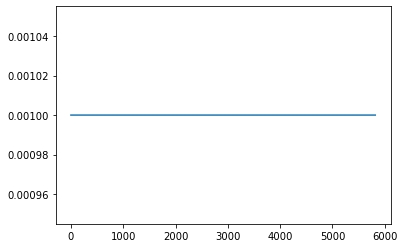

In [13]:
# plor learning rate change
lr = np.array(lrs)[:,1]
plt.plot(np.arange(len(lr)), lr)

In [14]:
model1_8, statistics, lrs = train_model(model1_8, criterion8, optimizer8, cosine_lr_scheduler, num_epochs=num_epochs, sch=False)

Epoch 0/59
----------
train Loss: 1.7732 Acc: 0.5613
eval Loss: 1.7544 Acc: 0.6061

Epoch 1/59
----------
train Loss: 1.7505 Acc: 0.5724
eval Loss: 1.5987 Acc: 0.6195

Epoch 2/59
----------
train Loss: 1.7647 Acc: 0.5696
eval Loss: 1.6082 Acc: 0.6134

Epoch 3/59
----------
train Loss: 1.6810 Acc: 0.5854
eval Loss: 1.5817 Acc: 0.6183

Epoch 4/59
----------
train Loss: 1.7036 Acc: 0.5873
eval Loss: 1.5086 Acc: 0.6268

Epoch 5/59
----------
train Loss: 1.6790 Acc: 0.5863
eval Loss: 1.5525 Acc: 0.6195

Epoch 6/59
----------
train Loss: 1.6579 Acc: 0.5901
eval Loss: 1.5110 Acc: 0.6244

Epoch 7/59
----------
train Loss: 1.6834 Acc: 0.5868
eval Loss: 1.5404 Acc: 0.6317

Epoch 8/59
----------
train Loss: 1.6378 Acc: 0.5979
eval Loss: 1.5205 Acc: 0.6329

Epoch 9/59
----------
train Loss: 1.6509 Acc: 0.5990
eval Loss: 1.5114 Acc: 0.6293

Epoch 10/59
----------
train Loss: 1.6045 Acc: 0.5970
eval Loss: 1.4782 Acc: 0.6366

Epoch 11/59
----------
train Loss: 1.6056 Acc: 0.6094
eval Loss: 1.4387 Acc

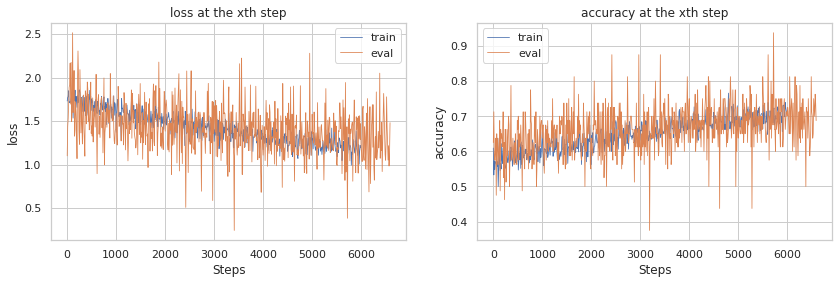

In [15]:
num_epochs=60
def visualize_accuracy(num_epochs, statistics):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist))*10, loss_hist, label = phase, linewidth = 0.8)
#         ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.set(xlabel = 'Steps', ylabel='loss',title='loss at the xth step');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist))*10, acc_hist, label = phase, linewidth = 0.8)
#         ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.set(xlabel = 'Steps', ylabel='accuracy',title='accuracy at the xth step');
        ax2.legend();
    fig.savefig('acc_loss_model1_8.png')
visualize_accuracy(num_epochs, statistics)

In [ ]:
# PATH = '/kaggle/working/model1_8.pth'
# torch.save(model1_8.state_dict(), PATH)
# PATH = '/kaggle/working/whole model1_8.pth'
# torch.save(model1_8, PATH)

In [ ]:
# from IPython.display import FileLink
# FileLink(model1_8.pth)

## test acc: 0.71

In [16]:
# correct = 0
# total = 0
# class_correct = list(0. for i in range(num_classes))
# class_total = list(0. for i in range(num_classes))

# with torch.no_grad():
#     for count,data in enumerate(dataloaders['test']):
#         inputs, labels = data[0].to(device), data[1].to(device)
#         outputs = model1_8(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         c = (predicted == labels).squeeze() # 去除size为1的维度
#         for i in range(len(labels)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
        
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#         if count % 99 == 1:
#             print('still testing...')

# print('Accuracy of model1 on test images: %d %%' % (100 * correct / total))
# acc_dic = {}
# for i in range(num_classes):
#     acc = 100 * class_correct[i] / class_total[i]
#     acc_dic[class_names[i]] = acc
#     print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

NameError: name 'model1' is not defined